In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from utils.dataset import load_dataset_v2, create_lstm_dataset

In [2]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))
    
dataset= load_dataset_v2(file_path_list)

dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset.reset_index(drop=True, inplace=True)

dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

extra_column_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
extra_feature = pd.DataFrame()

for col_name in extra_column_name_list:
    extra_feature['grad_'+col_name] = np.gradient(dataset[col_name].to_numpy())

dataset = pd.concat([dataset, extra_feature], axis=1)

dataset_value = dataset.drop(columns=['reserved', 'time(s)', 'test_case', 'test_case_iter'])
dataset_value = pd.concat([dataset_value, extra_feature], axis=1)

feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)', 'grad_pressure_1(bar)', 'grad_main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_feature = train_data[feature_col_name_list]
train_feature.reset_index(drop=True, inplace=True)

train_target = pd.DataFrame(train_data[target_col_name])
train_target.reset_index(drop=True, inplace=True)

val_feature = val_data[feature_col_name_list]
val_feature.reset_index(drop=True, inplace=True)

val_target = pd.DataFrame(val_data[target_col_name])
val_target.reset_index(drop=True, inplace=True)

loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

<AxesSubplot:>

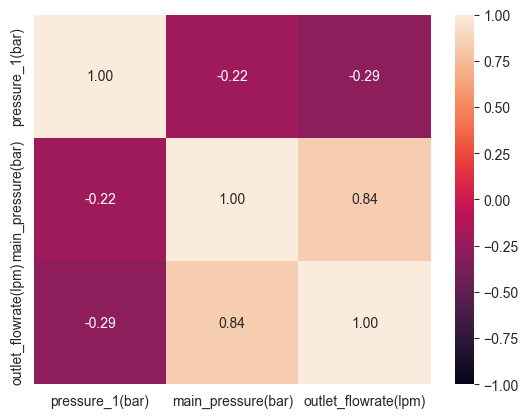

In [3]:
val_data_slice = val_data.copy()
val_data_slice = val_data_slice[['pressure_1(bar)', 'main_pressure(bar)', 'outlet_flowrate(lpm)']]
sns.heatmap(val_data_slice.corr(), annot=True, fmt='.2f', vmax=1, vmin=-1)


<AxesSubplot:>

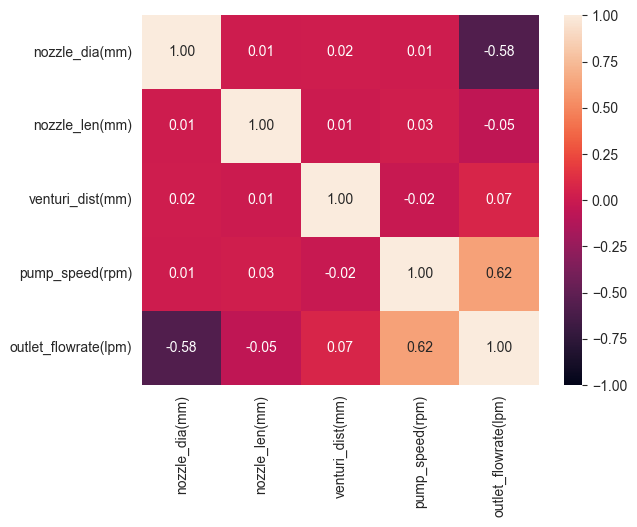

In [4]:
val_data_slice = val_data.copy()
val_data_slice = val_data_slice[['nozzle_dia(mm)', 'nozzle_len(mm)', 'venturi_dist(mm)', 'pump_speed(rpm)', 'outlet_flowrate(lpm)']]
sns.heatmap(val_data_slice.corr(), annot=True, fmt='.2f', vmax=1, vmin=-1)


In [5]:
seq_len = 30
pred_distance = 0

train_feature_lstm, train_target = create_lstm_dataset(train_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
val_feature_lstm, val_target = create_lstm_dataset(val_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)

In [6]:
train_pred = np.squeeze(pd.read_csv('result/train_pred.csv').to_numpy())
val_pred = np.squeeze(pd.read_csv('result/val_pred.csv').to_numpy())

In [7]:
print(r2_score(train_target, train_pred), mean_absolute_error(train_target, train_pred), mean_absolute_percentage_error(train_target, train_pred))

0.960176423281322 67.39041079137418 0.19359642121534604


In [8]:
print(r2_score(val_target, val_pred), mean_absolute_error(val_target, val_pred), mean_absolute_percentage_error(val_target, val_pred))

0.9487211007943078 76.73968487564687 0.23669182848307108


In [9]:
val_data_slice = val_data.copy()
val_data_slice = val_data_slice[29:]
val_data_slice['abs_error'] = np.abs(val_target-val_pred)
val_data_slice['relative_error'] = (np.abs(val_target-val_pred)/val_target)*100

In [10]:
pump_speed_1_df = val_data_slice[(val_data_slice['pump_speed(rpm)'] > 850) & (val_data_slice['pump_speed(rpm)'] < 950)]
pump_speed_1_df.reset_index(drop=True, inplace=True)
pump_speed_1_df_fix = pump_speed_1_df.copy()
pump_speed_1_df_fix['pump_speed(rpm)'] = 900

pump_speed_2_df = val_data_slice[(val_data_slice['pump_speed(rpm)'] > 1150) & (val_data_slice['pump_speed(rpm)'] < 1250)]
pump_speed_2_df.reset_index(drop=True, inplace=True)
pump_speed_2_df_fix = pump_speed_2_df.copy()
pump_speed_2_df_fix['pump_speed(rpm)'] = 1200

pump_speed_3_df = val_data_slice[(val_data_slice['pump_speed(rpm)'] > 1450) & (val_data_slice['pump_speed(rpm)'] < 1550)]
pump_speed_3_df.reset_index(drop=True, inplace=True)
pump_speed_3_df_fix = pump_speed_3_df.copy()
pump_speed_3_df_fix['pump_speed(rpm)'] = 1500

pump_speed_df = pd.concat([pump_speed_1_df_fix, pump_speed_2_df_fix, pump_speed_3_df_fix])

In [13]:
stats = pump_speed_1_df_fix[['relative_error', 'abs_error']].describe()
stats

,relative_error,abs_error
count,23881.000000,23881.000000
mean,42.621133,109.974507
std,1071.720258,99.578798
min,0.000007,0.000020
25%,5.547717,35.062600
50%,14.880448,81.109250
75%,32.787108,160.527300
max,136551.168317,1379.166800


In [47]:
x=[0, 15, 30, 60]
y=[93, 104, 1143, 184]
np.corrcoef(x, y)

array([[1.        , 0.17579431],
       [0.17579431, 1.        ]])

In [40]:
val_data_slice[val_data_slice['venturi_dist(mm)'] == 60][['relative_error', 'abs_error']].describe()

,relative_error,abs_error
count,21438.000000,21438.000000
mean,19.648524,87.697307
std,184.917113,77.902390
min,0.000272,0.001700
25%,3.473893,34.723000
50%,6.463838,72.016200
75%,14.120338,115.910525
max,15937.853543,1364.324300


Text(0, 0.5, 'Absolute Error(LPM)')

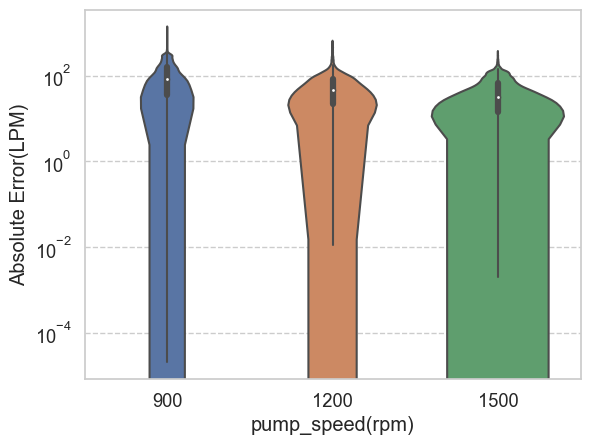

In [120]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=pump_speed_df, x='pump_speed(rpm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

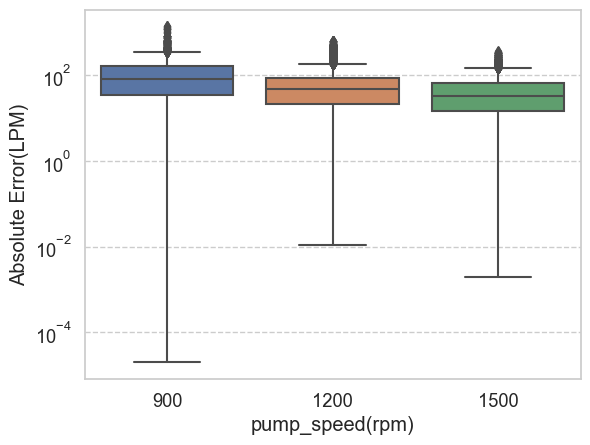

In [121]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=pump_speed_df, x='pump_speed(rpm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

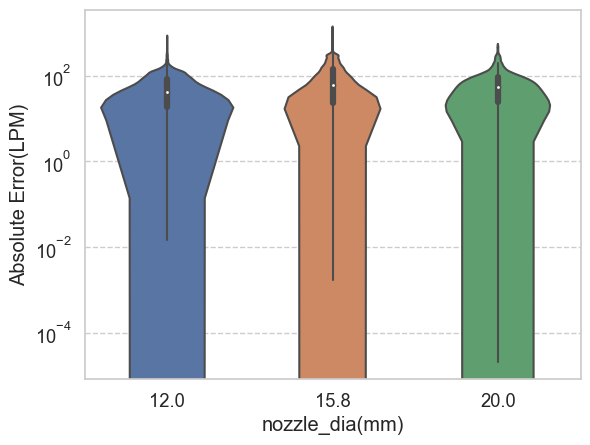

In [122]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=val_data_slice, x='nozzle_dia(mm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

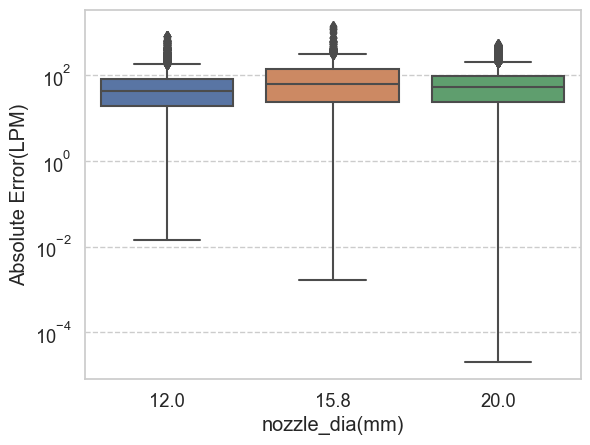

In [123]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, x='nozzle_dia(mm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

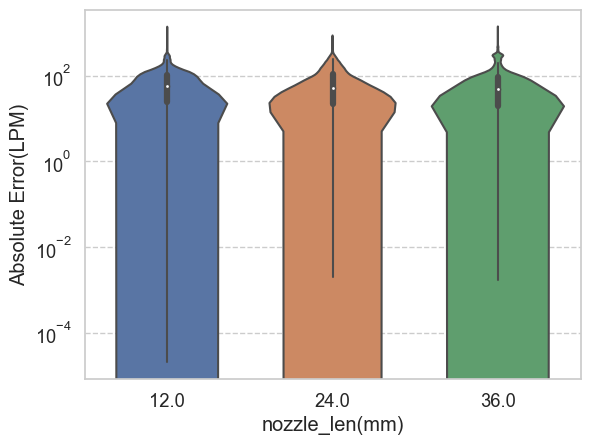

In [124]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=val_data_slice, x='nozzle_len(mm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

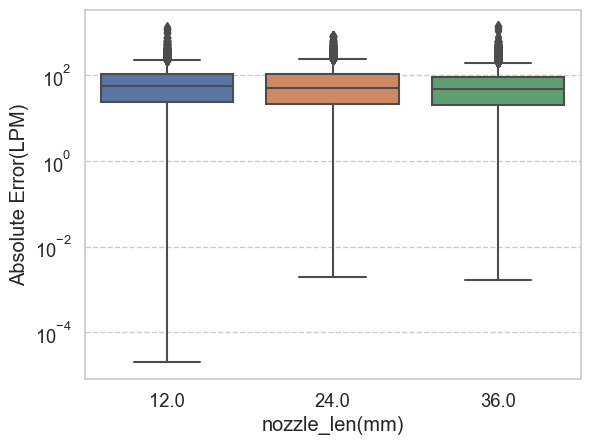

In [125]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, x='nozzle_len(mm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

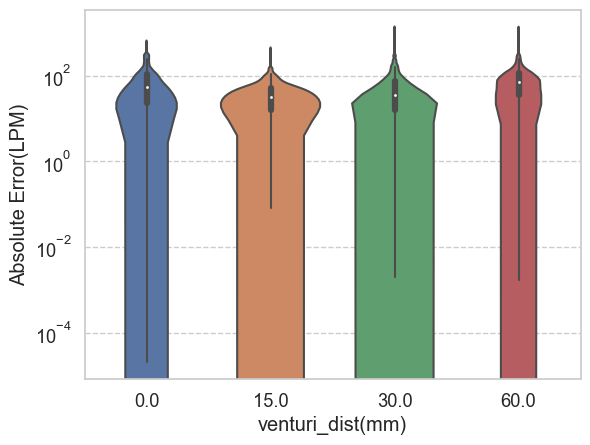

In [126]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=val_data_slice, x='venturi_dist(mm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Absolute Error(LPM)')

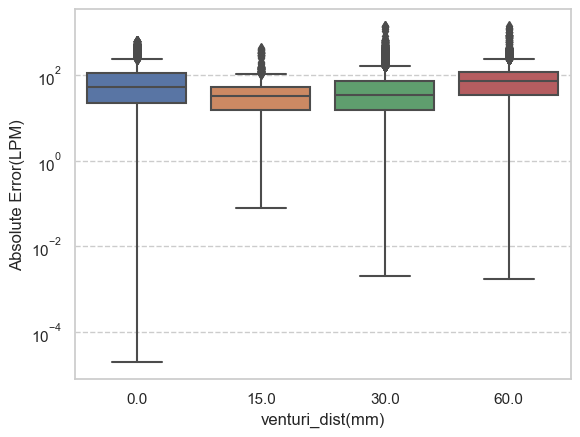

In [127]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, x='venturi_dist(mm)', y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(LPM)')

Text(0, 0.5, 'Relative Error(%)')

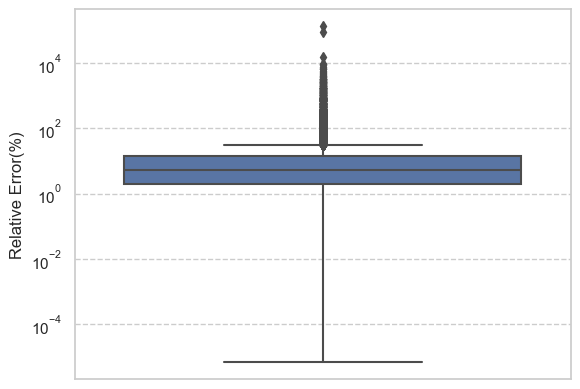

In [104]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'ABsolute Error(lpm)')

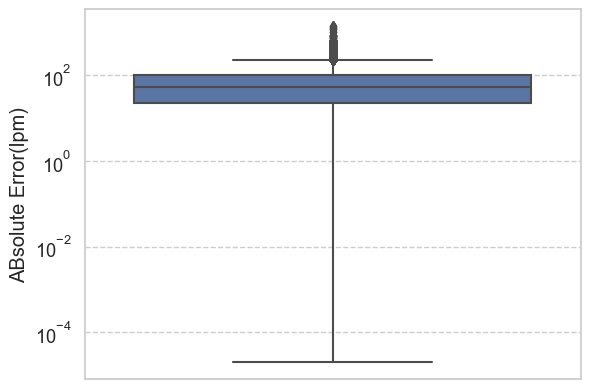

In [106]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, y='abs_error')

plt.yscale('log')
plt.ylabel('Absolute Error(lpm)')

In [117]:
stats = val_data_slice[['relative_error', 'abs_error']].describe()
stats

,relative_error,abs_error
count,63971.00000,63971.00000
mean,23.66918,76.73968
std,660.34708,81.52388
min,0.00001,0.00002
25%,1.95515,21.89060
50%,5.23112,51.47935
75%,13.87988,101.76162
max,136551.16832,1379.16680


In [80]:
iqr = (stats.loc['75%']['relative_error'] - stats.loc['25%']['relative_error'])
upper = (stats.loc['75%']['relative_error']+1.5)*(stats.loc['75%']['relative_error'] - stats.loc['25%']['relative_error'])
lower = (stats.loc['25%']['relative_error']-1.5)*(stats.loc['75%']['relative_error'] - stats.loc['25%']['relative_error'])
temp = val_data_slice[val_data_slice['relative_error'] < upper]
temp = temp[temp['relative_error'] > lower]

temp[['relative_error', 'abs_error']].describe()

,relative_error,abs_error
count,30732.00000,30732.00000
mean,24.98313,126.18891
std,26.94849,82.98176
min,5.42783,0.30652
25%,8.02367,70.04810
50%,13.95626,102.39656
75%,30.57087,157.04168
max,182.45123,657.31620


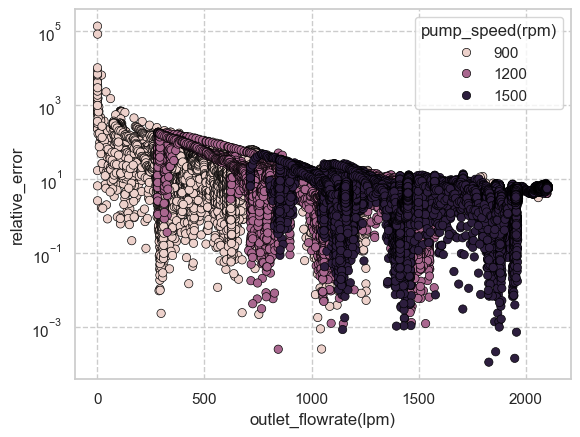

In [88]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=pump_speed_df, x='outlet_flowrate(lpm)', y='relative_error', hue='pump_speed(rpm)', edgecolor='black')

plt.yscale('log')

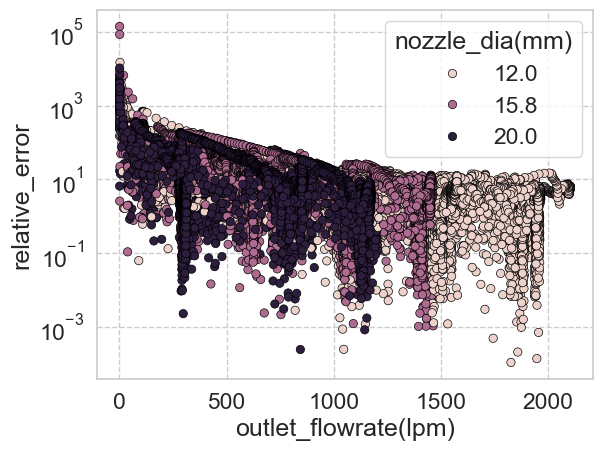

In [36]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=val_data_slice, x='outlet_flowrate(lpm)', y='relative_error', hue='nozzle_dia(mm)',  edgecolor='black')

plt.yscale('log')

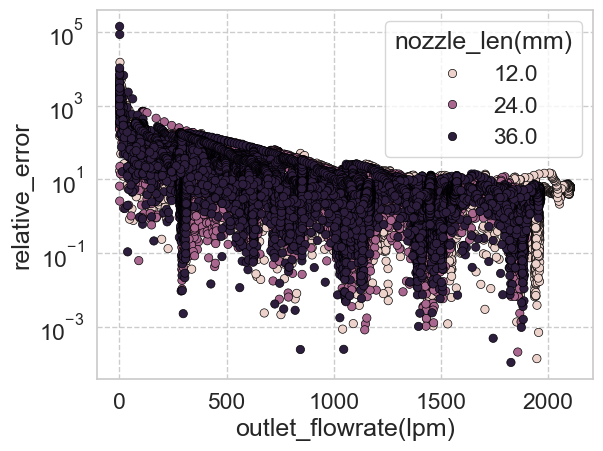

In [37]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=val_data_slice, x='outlet_flowrate(lpm)', y='relative_error', hue='nozzle_len(mm)', edgecolor='black')

plt.yscale('log')

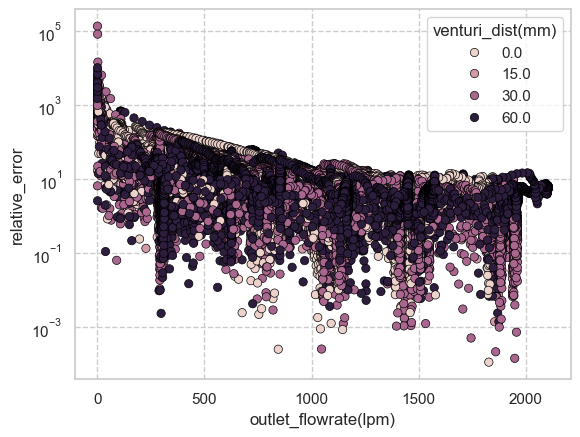

In [39]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=val_data_slice, x='outlet_flowrate(lpm)', y='relative_error', hue='venturi_dist(mm)', edgecolor='black')

plt.yscale('log')

Text(0.5, 0, 'Absolute Error(lpm)')

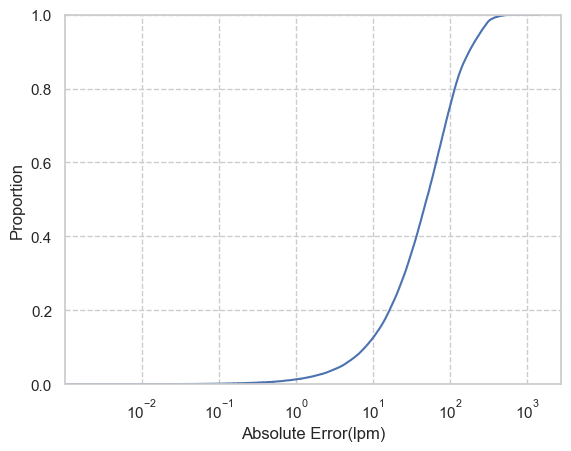

In [97]:
sns.ecdfplot(val_data_slice['abs_error'])
plt.xscale('log')
plt.xlabel('Absolute Error(lpm)')

Text(0, 0.5, 'Relative Error(%)')

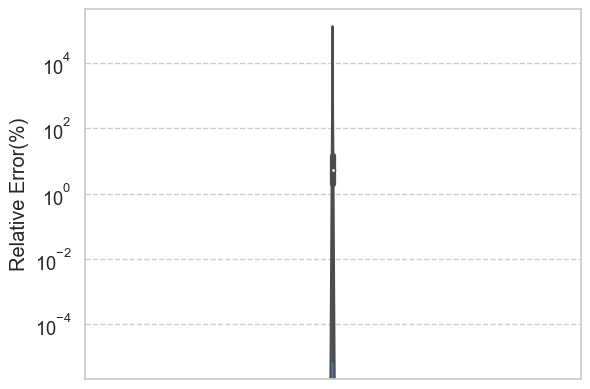

In [57]:
sns.violinplot(data=val_data_slice, y='relative_error')
plt.yscale('log')
plt.ylabel('Relative Error(%)')

In [ ]:
plt.xscale('log')
plt.xlabel('Relative Error(%)')

Text(0.5, 0, 'Relative Error(%)')

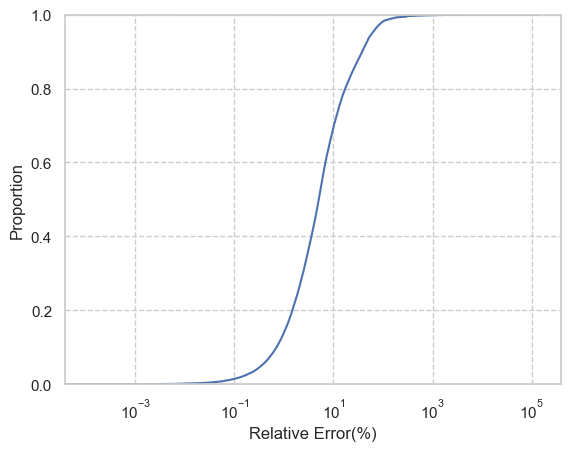

In [98]:
sns.ecdfplot(val_data_slice['relative_error'])
plt.xscale('log')
plt.xlabel('Relative Error(%)')